
# HELOC Risk Prediction


### Introduction

This project aims at developing a predictive model and a decision support system (DSS) that evaluates the risk of Home Equity Line of Credit (HELOC) applications. 

We are assigned with a real-world financial dataset from an anonymized credit bureau.The 23 predictor variables are either quantitative or categorical. The target variable that we are going to predict is a binary variable called RiskPerformance. The value “Bad” means that a consumer was 90 days past due or worse at least once over a period of 24 months from when the credit account was opened. The value “Good” indicates that they have made their payments without ever being more than 90 days overdue. 

### Import Library

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import Imputer

### Load the data 

In [2]:
heloc = pd.read_csv('heloc_dataset_v1.csv')
heloc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10459 entries, 0 to 10458
Data columns (total 24 columns):
RiskPerformance                       10459 non-null object
ExternalRiskEstimate                  10459 non-null int64
MSinceOldestTradeOpen                 10459 non-null int64
MSinceMostRecentTradeOpen             10459 non-null int64
AverageMInFile                        10459 non-null int64
NumSatisfactoryTrades                 10459 non-null int64
NumTrades60Ever2DerogPubRec           10459 non-null int64
NumTrades90Ever2DerogPubRec           10459 non-null int64
PercentTradesNeverDelq                10459 non-null int64
MSinceMostRecentDelq                  10459 non-null int64
MaxDelq2PublicRecLast12M              10459 non-null int64
MaxDelqEver                           10459 non-null int64
NumTotalTrades                        10459 non-null int64
NumTradesOpeninLast12M                10459 non-null int64
PercentInstallTrades                  10459 non-null int64
MSinc

In [3]:
heloc.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,...,25,0,1,1,51,89,3,1,0,80


### Data Cleaning and Data Preprocessing

1) Dealing with missing values and special values

There are no NaN in the original data.But accoring to the data dictionary,1 in column MaxDelqEver represents No such value and -9 in all columns represents No Bureau Record or No Investigation.Thus,we replaced these value with ‘nan’ and dropped rows containing these values. 

In [4]:
heloc['MaxDelqEver'] =heloc['MaxDelqEver'].replace(1, np.nan)
heloc =heloc.replace(-9, np.nan)
heloc = heloc.dropna()

Other special values: -7 and -8 in all columns means invalid values. We replaced these values with mode value of the corresponding feature using Imputer.

In [5]:
heloc = heloc.replace(-8, np.nan)
heloc = heloc.replace(-7, np.nan)

imputer = Imputer(strategy="most_frequent")
for i in range(1,24):
    heloc.iloc[:, [i]] = imputer.fit_transform(heloc.iloc[:, [i]])

2) Converting the data types

For variables MaxDelq2PublicRecLast12M and MaxDelqEver, they are categorical variables that represent related records of max delinquency. These variables are converted into categorical variables to facilitate model building. 

In [6]:
categorical1 = pd.get_dummies(heloc['MaxDelq2PublicRecLast12M'],prefix='MaxDelq2PublicRecLast12M')
categorical2 = pd.get_dummies(heloc['MaxDelqEver'],prefix='MaxDelqEver')
heloc = pd.concat([heloc, categorical1,categorical2],axis = 1)

The target variable to predict the risk is the RiskPerformance. The original data consists of two values: good and bad. RiskPeformance is factorized to 0 and 1. 0 represents bad and 1 represents good.

In [7]:
heloc['RiskPerformance']=pd.factorize(heloc['RiskPerformance'])[0]
heloc.head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,MaxDelq2PublicRecLast12M_6.0,MaxDelq2PublicRecLast12M_7.0,MaxDelq2PublicRecLast12M_9.0,MaxDelqEver_2.0,MaxDelqEver_3.0,MaxDelqEver_4.0,MaxDelqEver_5.0,MaxDelqEver_6.0,MaxDelqEver_7.0,MaxDelqEver_8.0
0,0,55.0,144.0,4.0,84.0,20.0,3.0,0.0,83.0,2.0,...,0,0,0,0,0,0,1,0,0,0
1,0,61.0,58.0,15.0,41.0,2.0,4.0,4.0,100.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2,0,67.0,66.0,5.0,24.0,9.0,0.0,0.0,100.0,1.0,...,0,1,0,0,0,0,0,0,0,1
3,0,66.0,169.0,1.0,73.0,28.0,1.0,1.0,93.0,76.0,...,1,0,0,0,0,0,0,1,0,0
4,0,81.0,333.0,27.0,132.0,12.0,0.0,0.0,100.0,1.0,...,0,1,0,0,0,0,0,0,0,1


#### Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000DEC25CE208>,
      dtype=object)

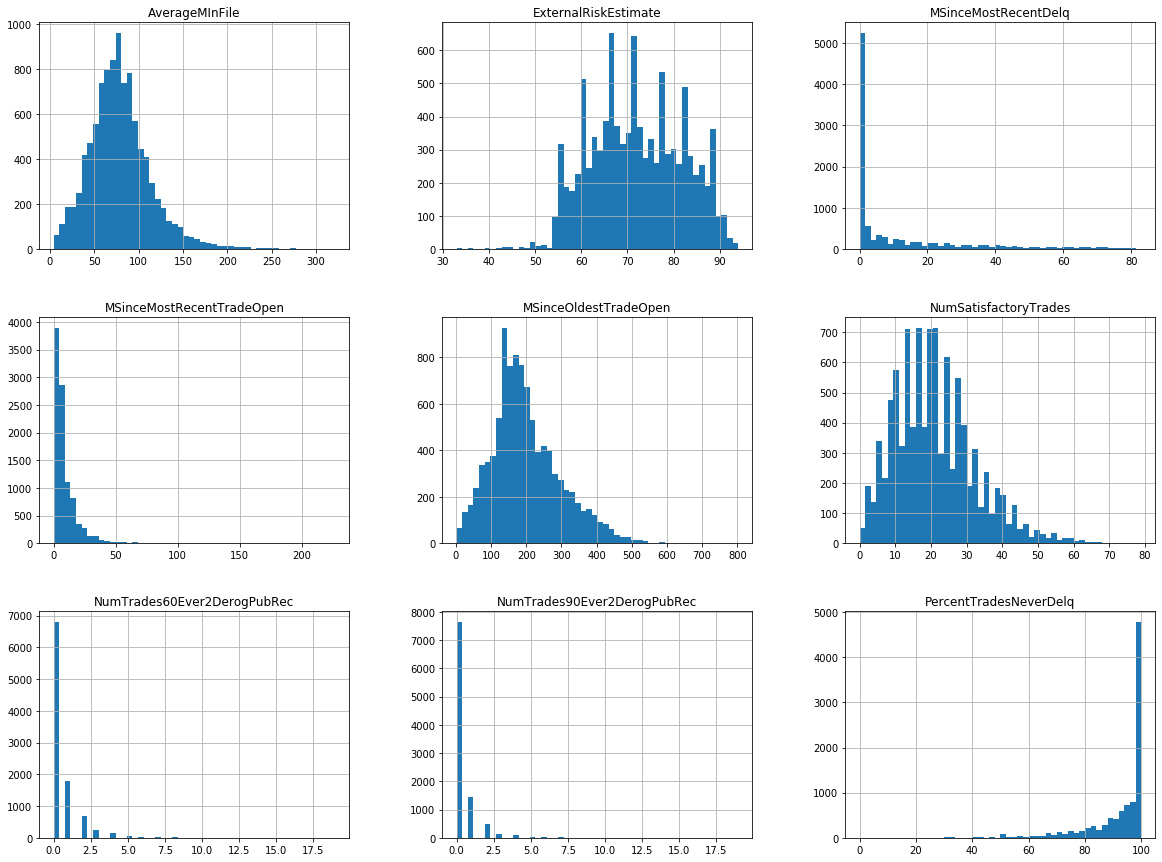

In [27]:
heloc.iloc[:,1:10].hist(bins=50, figsize=(20,15))

From the charts above, we could see measurement unit of each feature of the system are different.Thus,we need to standardize features using standard scaler for some machine learning models that are sensitive to the scale of the number.

### Building and Tuning Model

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import tree  
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

In [29]:
model_names = ['LR','LDA','KNN','DT','RF','GB']

# the training parameters of each model
param_grid_lr = [{'C':[0.01,0.1,1],'random_state':[1]}]
param_grid_dt =[{ 'max_features':range(1,20),'max_depth':range(1,50),'random_state':[1]}]
param_grid_rf = [{ 'n_estimators':[50, 100,150,200],'max_features':[0.2, 0.3, 0.5, 0.8], 'bootstrap':[True],'random_state':[1]}]
param_grid_gb= [{ 'n_estimators': [25, 50, 80, 100, 200],
                 'learning_rate': [.05, .1, .2,.5,1], 
                 'max_depth': [1,3,5],
                 'random_state':[1]}]
param_grid_lda = [{}]
param_grid_knn =[{},{'n_neighbors':[1,2,3,4,5]}]       

classifiers= [(LogisticRegression(), model_names[0], param_grid_lr),
              (LinearDiscriminantAnalysis(), model_names[1], param_grid_lda),
            (neighbors.KNeighborsClassifier(), model_names[2], param_grid_knn),
            (tree.DecisionTreeClassifier(), model_names[3], param_grid_dt),
            (RandomForestClassifier(), model_names[4], param_grid_rf),
            (GradientBoostingClassifier(), model_names[5], param_grid_gb)]



def evaluate_model1(heloc, model, model_name, params):
  
    X = heloc.drop(["RiskPerformance"], axis=1)
    y = heloc["RiskPerformance"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    #scale data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    grid_search = GridSearchCV(model, params, cv=5,n_jobs=-1,scoring='accuracy') 
    grid_search.fit(X_train,y_train)
       
    model_selection = grid_search.best_estimator_ 
    predictions = model_selection.predict(X_test)

    accuracy = (y_test==predictions).mean() 
    model_dic = {} 
    model_dic['Classifier'] = model_name 
    model_dic['Best Parameter'] = grid_search.best_estimator_.get_params()
    model_dic['CV Accuracy'] = grid_search.best_score_ 
    model_dic['Overall Accuracy'] = accuracy 
    return model_dic

def evaluate_model2(heloc, model, model_name, params):
  
    X = heloc.drop(["RiskPerformance"], axis=1)
    y = heloc["RiskPerformance"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
    grid_search = GridSearchCV(model, params, cv=5,n_jobs=-1,scoring='accuracy') 
    grid_search.fit(X_train,y_train)
       
    model_selection = grid_search.best_estimator_ 
    predictions = model_selection.predict(X_test)

    accuracy = (y_test==predictions).mean() 
    model_dic = {} 
    model_dic['Classifier'] = model_name 
    model_dic['Best Parameter'] = grid_search.best_estimator_.get_params()
    model_dic['CV Accuracy'] = grid_search.best_score_ 
    model_dic['Overall Accuracy'] = accuracy 
    return model_dic


In [30]:
res_list = []
for i in range(len(classifiers)):
    if i<3:
        res_list.append(evaluate_model1(heloc, classifiers[i][0], classifiers[i][1], classifiers[i][2]))
    else:
        res_list.append(evaluate_model2(heloc, classifiers[i][0], classifiers[i][1], classifiers[i][2]))
    
result_table = pd.DataFrame(res_list, columns = ['Classifier','Best Parameter','CV Accuracy','Overall Accuracy']).sort_values(by=['Classifier']).reset_index(drop=True)
    
    
result_table

,Classifier,Best Parameter,CV Accuracy,Overall Accuracy
0,DT,"{'class_weight': None, 'criterion': 'gini', 'm...",0.718053,0.708566
1,GB,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.734026,0.720730
2,KNN,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.694980,0.677648
3,LDA,"{'n_components': None, 'priors': None, 'shrink...",0.733266,0.718196
4,LR,"{'C': 1, 'class_weight': None, 'dual': False, ...",0.736435,0.714648
5,RF,"{'bootstrap': True, 'class_weight': None, 'cri...",0.734533,0.721237


In [31]:
result_table.iloc[5,1]

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 0.2,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

### Interface Preparation

In [8]:
import pickle
from sklearn.pipeline import Pipeline

In [16]:
data_dict={}
X = heloc.drop(["RiskPerformance"], axis=1)
y = heloc["RiskPerformance"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
    
data_dict['X_train'] = X_train
data_dict['X_test'] = X_test
data_dict['y_train'] = y_train
data_dict['y_test'] = y_test

In [17]:
pipe_rf = Pipeline([('standard scaler', MinMaxScaler()), 
                    ('Random Forest',RandomForestClassifier(bootstrap = True,
                                                             class_weight = None,
                                                             criterion = 'gini',
                                                             max_depth = None,
                                                             max_features = 0.2,
                                                             max_leaf_nodes = None,
                                                             min_impurity_decrease = 0.0,
                                                             min_impurity_split = None,
                                                             min_samples_leaf = 1,
                                                             min_samples_split = 2,
                                                             min_weight_fraction_leaf = 0.0,
                                                             n_estimators = 150,
                                                             n_jobs = None,
                                                             oob_score = False,
                                                             random_state = 1,
                                                             verbose = 0,
                                                             warm_start = False))])
pipe_rf.fit(X_train,y_train)


Pipeline(memory=None,
         steps=[('standard scaler',
                 MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('Random Forest',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=0.2, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=150, n_jobs=None,
                                        oob_score=False, random_state=1,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [18]:
pickle.dump(data_dict['X_train'], open("X_train.sav", "wb"))
pickle.dump(data_dict['X_test'], open("X_test.sav", "wb"))
pickle.dump(y_test, open("y_test.sav", "wb"))
pickle.dump(y_train, open("y_train.sav", "wb"))
pickle.dump(pipe_rf, open("pipe_rf.sav", "wb"))